Import library yang penting

In [120]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam

Load Dataset

In [121]:
df = pd.read_csv('vehicles.csv', low_memory=False)
print("Loaded dataset shape:", df.shape)
display(df.head())

Loaded dataset shape: (49529, 84)


,barrels08,barrelsA08,charge120,charge240,city08,city08U,cityA08,cityA08U,cityCD,cityE,...,mfrCode,c240Dscr,charge240b,c240bDscr,createdOn,modifiedOn,startStop,phevCity,phevHwy,phevComb
0,14.167143,0.0,0.0,0.0,19,0.0,0,0.0,0.0,0.0,...,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0
1,27.046364,0.0,0.0,0.0,9,0.0,0,0.0,0.0,0.0,...,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0
2,11.018889,0.0,0.0,0.0,23,0.0,0,0.0,0.0,0.0,...,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0
3,27.046364,0.0,0.0,0.0,10,0.0,0,0.0,0.0,0.0,...,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0
4,15.658421,0.0,0.0,0.0,17,0.0,0,0.0,0.0,0.0,...,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0


Cek kolom dan pilih kolom yang dipakai untuk deep learning

In [122]:
# Target: comb08 (combined MPG)
if 'comb08' not in df.columns:
    raise SystemExit("Kolom 'comb08' tidak ditemukan. Pastikan file vehicles.csv benar.")

# Memilih kolom yang agak digunakan untuk deep learning
cols_candidate = [
    'make', 'model', 'year', 'displ', 'cylinders', 'fuelType', 'fuelType2',
    'trany', 'drive', 'VClass'
]
cols = [c for c in cols_candidate if c in df.columns]
print("Using columns:", cols)

df = df[df['comb08'].notna()].copy()

Using columns: ['make', 'model', 'year', 'displ', 'cylinders', 'fuelType', 'fuelType2', 'trany', 'drive', 'VClass']


Membersihkan dataset dan konversi tipe data menjadi numerik

In [123]:
# Konversi kolom "numerik-like" menjadi numerik asli
numeric_cols = ['displ', 'cylinders', 'year']
for c in numeric_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

#Hapus baris yang mengandung NaN
need_numeric = ['displ', 'cylinders', 'comb08']
need_numeric = [c for c in need_numeric if c in df.columns]
df.dropna(subset=need_numeric, inplace=True)

print("After cleaning shape:", df.shape)

After cleaning shape: (48179, 84)


Feature engineering

In [124]:
#  - displacement_per_cyl
#  - year_age (relative age)
#  - engine_size_indicator (displ)
df['displacement_per_cyl'] = df['displ'] / df['cylinders']
df['vehicle_age'] = df['year'].max() - df['year']  # lebih baru -> lebih muda

# Hapus nilai yang absurd
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(subset=['displacement_per_cyl'], inplace=True)

/tmp/ipython-input-860913891.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace([np.inf, -np.inf], np.nan, inplace=True)


Categorical Handling

In [125]:
def top_n_to_other(series, n=20):
    top = series.value_counts().nlargest(n).index
    return series.where(series.isin(top), other='Other')

if 'make' in df.columns:
    df['make_reduced'] = top_n_to_other(df['make'], n=20)
if 'VClass' in df.columns:
    df['VClass_reduced'] = top_n_to_other(df['VClass'], n=20)

# pilih fitur untuk model:
feature_cols = []
# numeric base
for c in ['displ', 'cylinders', 'vehicle_age', 'displacement_per_cyl']:
    if c in df.columns:
        feature_cols.append(c)

# Kategorikal tereduksi (akan dilakukan one-hot encoding)
cat_cols = []
for c in ['make_reduced', 'fuelType', 'trany', 'VClass_reduced']:
    if c in df.columns:
        cat_cols.append(c)

print("Numeric features used:", feature_cols)
print("Categorical features used:", cat_cols)

#encode kolom kategorikal yang dipilih dengan pandas.get_dummies)
df_enc = pd.get_dummies(df[cat_cols].astype(str), drop_first=False)
print("One-hot shape:", df_enc.shape)

# Mengumpulkan semua fitur menjadi satu paket yang siap dilatih
X_numeric = df[feature_cols].reset_index(drop=True)
X = pd.concat([X_numeric, df_enc.reset_index(drop=True)], axis=1)
y = df['comb08'].reset_index(drop=True)

print("Final X shape:", X.shape)
print("Final y shape:", y.shape)

Numeric features used: ['displ', 'cylinders', 'vehicle_age', 'displacement_per_cyl']
Categorical features used: ['make_reduced', 'fuelType', 'trany', 'VClass_reduced']
One-hot shape: (48179, 95)
Final X shape: (48179, 99)
Final y shape: (48179,)


Train-test split

In [126]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)
print("Train/test sizes:", X_train.shape[0], X_test.shape[0])

Train/test sizes: 38543 9636


Scaling numeric features

In [127]:
# Menskalakan kolom numerik, cari indeks nya
numeric_index = [X.columns.get_loc(col) for col in feature_cols]
scaler = StandardScaler()
X_train_num = X_train.iloc[:, numeric_index]
X_test_num = X_test.iloc[:, numeric_index]

scaler.fit(X_train_num)
X_train_scaled_num = scaler.transform(X_train_num)
X_test_scaled_num = scaler.transform(X_test_num)

# Ganti bagian numerik di X_train dan X_test
X_train_scaled = X_train.copy()
X_test_scaled  = X_test.copy()

for i, col in enumerate(feature_cols):
    X_train_scaled.iloc[:, X_train.columns.get_loc(col)] = X_train_scaled_num[:, i]
    X_test_scaled.iloc[:, X_test.columns.get_loc(col)] = X_test_scaled_num[:, i]

# Mengubah data Pandas DataFrame jadi NumPy arrays untuk Keras
X_train_arr = X_train_scaled.values.astype(np.float32)
X_test_arr  = X_test_scaled.values.astype(np.float32)
y_train_arr = y_train.values.astype(np.float32)
y_test_arr  = y_test.values.astype(np.float32)

print("Prepared numpy shapes:", X_train_arr.shape, X_test_arr.shape)

/tmp/ipython-input-750453997.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.28969626  0.13327359 -1.11810775 ... -1.35274175  0.83717559
 -0.25778308]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_train_scaled.iloc[:, X_train.columns.get_loc(col)] = X_train_scaled_num[:, i]
/tmp/ipython-input-750453997.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.83717559  0.36790759 -0.25778308 ... -1.35274175  1.38465493
  1.15002093]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_test_scaled.iloc[:, X_test.columns.get_loc(col)] = X_test_scaled_num[:, i]


Prepared numpy shapes: (38543, 99) (9636, 99)


Simple sequential model (regression)

In [128]:
input_dim = X_train_arr.shape[1]
model = Sequential([
     Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],),
          kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(64, activation='relu',
          kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(32, activation='relu'),
    Dense(1)  # output layer untuk regresi
])

# Optimizer pakai Adam
optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='mse',
              metrics=['mae'] )

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_37 (Dense)                │ (None, 128)            │        12,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,937 (93.50 KB)

 Trainable params: 23,553 (92.00 KB)

 Non-trainable params: 384 (1.50 KB)

Callbacks & training

In [129]:
early = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, min_lr=1e-6, verbose=1)

history = model.fit(
    X_train_arr, y_train_arr,
    validation_split=0.15,
    epochs=100,
    batch_size=64,
    callbacks=[early, reduce_lr],
    verbose=1
)


Epoch 1/100
512/512 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 157.9032 - mae: 10.0733 - val_loss: 7.9802 - val_mae: 1.9222 - learning_rate: 0.0010
Epoch 2/100
512/512 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 15.9505 - mae: 3.0039 - val_loss: 5.0530 - val_mae: 1.5525 - learning_rate: 0.0010
Epoch 3/100
512/512 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 13.6140 - mae: 2.7647 - val_loss: 4.9723 - val_mae: 1.5878 - learning_rate: 0.0010
Epoch 4/100
512/512 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 12.4124 - mae: 2.6392 - val_loss: 4.4353 - val_mae: 1.5125 - learning_rate: 0.0010
Epoch 5/100
512/512 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 10.9354 - mae: 2.4806 - val_loss: 5.7458 - val_mae: 1.6801 - learning_rate: 0.0010
Epoch 6/100
512/512 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 10.2755 - mae: 2.3952 - val_loss: 4.5045 - val_mae: 1.5347 - learning_rate: 0.0010
Epoch 7/100
512/512 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 9.2657 - mae: 2.2646 - val_loss: 4.5463 - val_mae: 1.5631 - learning_rat

Evaluasi pada set uji

In [130]:
y_pred = model.predict(X_test_arr).flatten()

mae = mean_absolute_error(y_test_arr, y_pred)
mse = mean_squared_error(y_test_arr, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_arr, y_pred)

print("\n=== Evaluation on TEST set ===")
print(f"MAE  : {mae:.3f}")
print(f"MSE  : {mse:.3f}")
print(f"RMSE : {rmse:.3f}")
print(f"R²   : {r2:.3f}")

302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

=== Evaluation on TEST set ===
MAE  : 1.143
MSE  : 2.444
RMSE : 1.563
R²   : 0.920


Grafik: kurva pelatihan dan perbandingan antara data aktual dan prediksi.

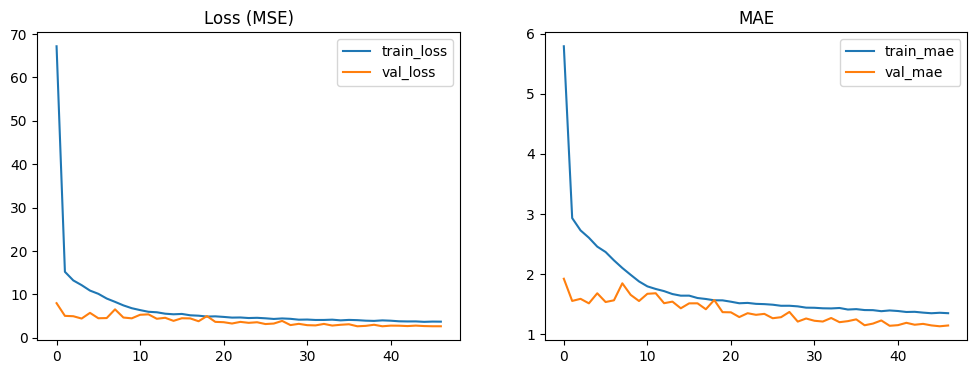

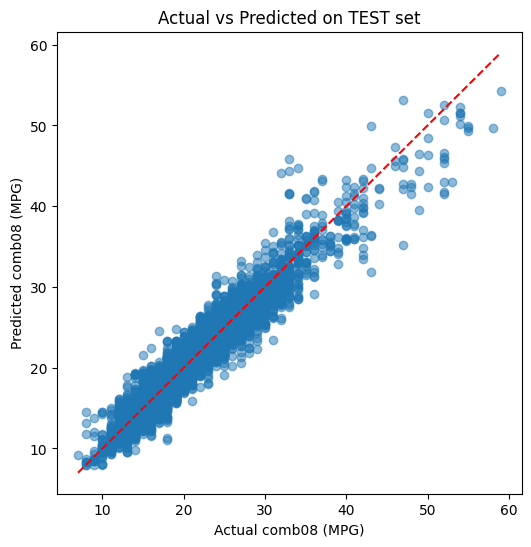

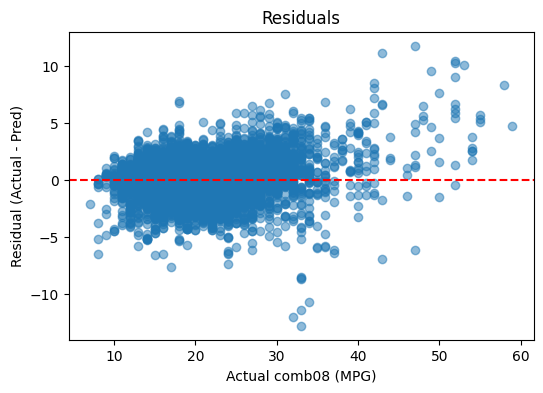

In [131]:
# Kurva pelatihan
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.title('Loss (MSE)')

plt.subplot(1,2,2)
plt.plot(history.history['mae'], label='train_mae')
plt.plot(history.history['val_mae'], label='val_mae')
plt.legend(); plt.title('MAE')
plt.show()

# Scatter Asli vs Prediksi
plt.figure(figsize=(6,6))
plt.scatter(y_test_arr, y_pred, alpha=0.5)
plt.plot([y_test_arr.min(), y_test_arr.max()], [y_test_arr.min(), y_test_arr.max()], 'r--')
plt.xlabel('Actual comb08 (MPG)')
plt.ylabel('Predicted comb08 (MPG)')
plt.title('Actual vs Predicted on TEST set')
plt.show()

# Residual plot
residuals = y_test_arr - y_pred
plt.figure(figsize=(6,4))
plt.scatter(y_test_arr, residuals, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Actual comb08 (MPG)')
plt.ylabel('Residual (Actual - Pred)')
plt.title('Residuals')
plt.show()


opsional: save model

In [132]:
# Save model and scaler if needed
model.save('mpg_dl_model.h5')
import joblib
joblib.dump(scaler, 'scaler.joblib')
print("Saved model to mpg_dl_model.h5 and scaler.joblib")

Saved model to mpg_dl_model.h5 and scaler.joblib
